In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer  
from sklearn.preprocessing import OneHotEncoder      
from sklearn.model_selection import KFold   
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from statistics import mean
from sklearn.model_selection import train_test_split
import joblib 
import lightgbm as lgb
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit, StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold, StratifiedKFold

# Additional useful imports
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import learning_curve
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, median_absolute_error
import seaborn as sns
from scipy import stats
import warnings

import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score

# **STEP 1: DATA COLLECTION**

In [2]:
btc_data = yf.download('BTC-USD', start='2010-01-01', end='2024-10-10', interval='1d')

[*********************100%***********************]  1 of 1 completed


In [3]:
# Header
print("______________________Overview of the Dataset_______________________")
print("\n")

# Print out the crawled data information
print(btc_data.head(4000),"\n")
print(btc_data.info())

______________________Overview of the Dataset_______________________


                    Open          High           Low         Close  \
Date                                                                 
2014-09-17    465.864014    468.174011    452.421997    457.334015   
2014-09-18    456.859985    456.859985    413.104004    424.440002   
2014-09-19    424.102997    427.834991    384.532013    394.795990   
2014-09-20    394.673004    423.295990    389.882996    408.903992   
2014-09-21    408.084991    412.425995    393.181000    398.821014   
...                  ...           ...           ...           ...   
2024-10-05  62067.609375  62371.023438  61689.582031  62089.949219   
2024-10-06  62084.988281  62959.570312  61833.148438  62818.953125   
2024-10-07  62819.109375  64443.707031  62152.550781  62236.660156   
2024-10-08  62221.644531  63174.304688  61843.562500  62131.968750   
2024-10-09  62131.726562  62508.835938  60314.613281  60582.101562   

               Adj

# **STEP 2: Prepare the incidicators**

**2.1: Add indicators to the data**

**Functions to create the indicators**

In [4]:
# Function to add indicators (e.g., moving averages, RSI)
def add_indicators(df):
    # Moving Averages (MA)
    df['MA_10'] = df['Close'].rolling(window=10).mean()  # 10-day Moving Average
    df['MA_50'] = df['Close'].rolling(window=50).mean()  # 50-day Moving Average
    df['MA_200'] = df['Close'].rolling(window=200).mean()  # 200-day Moving Average
    df['MA_20'] = df['Close'].rolling(window=20).mean()  # 20-day Moving Average (needed for Bollinger Bands)
    
    # Relative Strength Index (RSI)
    delta = df['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # Bollinger Bands (Upper and Lower Bands) - Uses MA_20
    df['BB_upper'] = df['MA_20'] + 2 * df['Close'].rolling(window=20).std()
    df['BB_lower'] = df['MA_20'] - 2 * df['Close'].rolling(window=20).std()
    
    # Exponential Moving Average (EMA)
    df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()  # 10-day Exponential Moving Average
    df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()  # 50-day Exponential Moving Average
    0
    return df

Việc xử lý các giá trị NaN trong dữ liệu là một bước quan trọng trong quy trình tiền xử lý dữ liệu. Câu hỏi về việc drop (loại bỏ) các hàng với giá trị NaN hay điền các giá trị thay thế (imputation) phụ thuộc vào loại dữ liệu, bài toán cụ thể, và cách bạn muốn mô hình học từ dữ liệu.

Lý do nên drop (loại bỏ) các hàng với giá trị NaN:
Dữ liệu thiếu có thể không đáng tin cậy: Nếu giá trị thiếu chiếm một phần nhỏ và không ảnh hưởng đến mẫu dữ liệu tổng thể, việc loại bỏ có thể tránh được việc tạo ra thông tin giả mạo hoặc làm méo mó dữ liệu thật.

Chỉ báo kỹ thuật cần các giá trị liền kề: Trong trường hợp các chỉ báo như Trung bình động (MA), RSI, hay Bollinger Bands, việc điền giá trị có thể không hợp lý vì các chỉ báo này phụ thuộc vào các giá trị thực tế liền kề. Ví dụ, điền vào một giá trị NaN trong Trung bình động có thể làm sai lệch thông tin về xu hướng.

Dữ liệu thiếu không nhiều: Nếu chỉ có một số hàng chứa NaN và số lượng này không đáng kể so với toàn bộ dữ liệu, việc loại bỏ các hàng đó sẽ không ảnh hưởng lớn đến kết quả dự đoán, nhưng lại giúp tránh sự phức tạp không cần thiết trong việc điền giá trị.

Lý do nên impute (điền vào giá trị thay thế) các giá trị NaN:
Bảo toàn kích thước dữ liệu: Nếu dữ liệu chứa nhiều hàng với NaN, việc loại bỏ các hàng này có thể làm giảm kích thước bộ dữ liệu đáng kể, dẫn đến mô hình kém hiệu quả hơn hoặc không có đủ thông tin để học.

Tránh mất thông tin: Loại bỏ các hàng có thể dẫn đến việc bỏ sót những thông tin quan trọng. Nếu các giá trị NaN xảy ra rải rác, việc điền giá trị vào có thể là lựa chọn hợp lý hơn.

Phương pháp điền giá trị thông minh: Bạn có thể sử dụng các phương pháp điền giá trị tiên tiến hơn, như:

Mean/Median/Mode imputation: Điền giá trị trung bình, trung vị hoặc mode của cột.
Forward fill hoặc Backward fill: Điền giá trị NaN bằng các giá trị trước hoặc sau nó.
KNN imputation: Sử dụng KNN để dự đoán giá trị thiếu dựa trên các điểm dữ liệu lân cận.
Iterative Imputer: Điền vào giá trị thiếu bằng cách dùng các cột khác để dự đoán giá trị của nó.
Ví dụ, nếu giá trị NaN xuất hiện trong cột 'Close', bạn có thể điền giá trị bằng giá trị trung bình của các ngày liền trước và liền sau.

In [5]:
# Add indicators to the dataset
btc_data = add_indicators(btc_data)

# Display the updated data with added indicators
print("\n______________________Dataset with Added Indicators_______________________")
print("\n")
print(btc_data.tail(10))  # Show the last 10 rows to check if indicators are added

# Drop rows with NaN values (due to moving averages and RSI calculations)
btc_data.dropna(inplace=True)

print("\n")
print(btc_data.info())


______________________Dataset with Added Indicators_______________________


                    Open          High           Low         Close  \
Date                                                                 
2024-09-30  65634.656250  65635.054688  62873.617188  63329.500000   
2024-10-01  63335.605469  64110.980469  60189.277344  60837.007812   
2024-10-02  60836.324219  62357.687500  59996.949219  60632.785156   
2024-10-03  60632.484375  61469.039062  59878.804688  60759.402344   
2024-10-04  60754.625000  62465.992188  60459.941406  62067.476562   
2024-10-05  62067.609375  62371.023438  61689.582031  62089.949219   
2024-10-06  62084.988281  62959.570312  61833.148438  62818.953125   
2024-10-07  62819.109375  64443.707031  62152.550781  62236.660156   
2024-10-08  62221.644531  63174.304688  61843.562500  62131.968750   
2024-10-09  62131.726562  62508.835938  60314.613281  60582.101562   

               Adj Close       Volume         MA_10         MA_50  \
Date        

# **STEP 3: Plotting to gain some insight of the data**

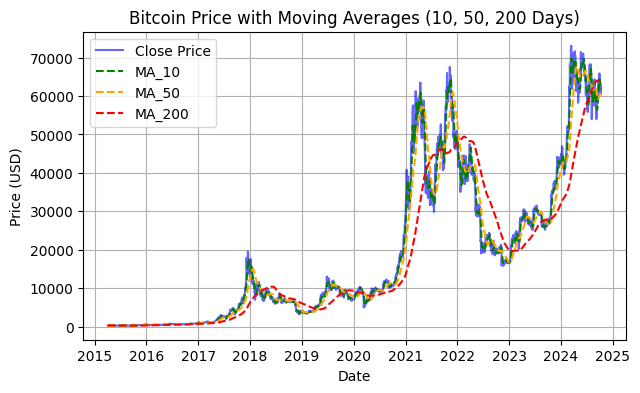

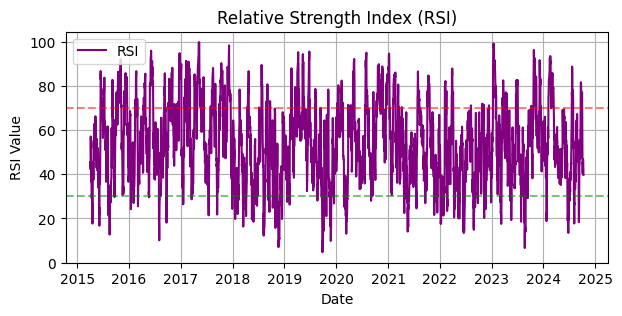

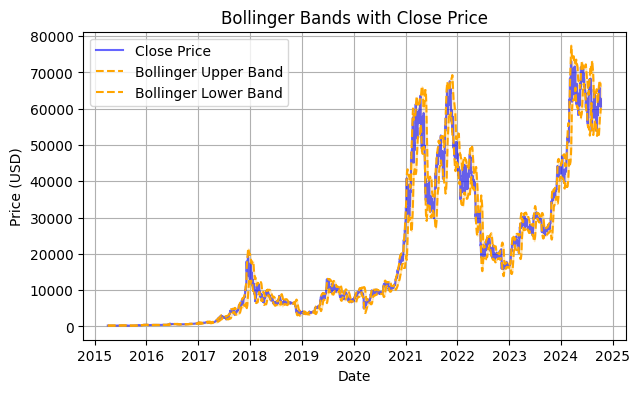

In [6]:
# Plotting price data along with Moving Averages
plt.figure(figsize=(7,4))
plt.plot(btc_data.index, btc_data['Close'], label='Close Price', color='blue', alpha=0.6)
plt.plot(btc_data.index, btc_data['MA_10'], label='MA_10', color='green', linestyle='--')
plt.plot(btc_data.index, btc_data['MA_50'], label='MA_50', color='orange', linestyle='--')
plt.plot(btc_data.index, btc_data['MA_200'], label='MA_200', color='red', linestyle='--')
plt.title('Bitcoin Price with Moving Averages (10, 50, 200 Days)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Plotting RSI (Relative Strength Index)
plt.figure(figsize=(7,3))
plt.plot(btc_data.index, btc_data['RSI'], label='RSI', color='purple')
plt.axhline(70, linestyle='--', alpha=0.5, color='red')  # Overbought level
plt.axhline(30, linestyle='--', alpha=0.5, color='green')  # Oversold level
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI Value')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Bollinger Bands along with the Closing Price
plt.figure(figsize=(7,4))
plt.plot(btc_data.index, btc_data['Close'], label='Close Price', color='blue', alpha=0.6)
plt.plot(btc_data.index, btc_data['BB_upper'], label='Bollinger Upper Band', color='orange', linestyle='--')
plt.plot(btc_data.index, btc_data['BB_lower'], label='Bollinger Lower Band', color='orange', linestyle='--')
plt.fill_between(btc_data.index, btc_data['BB_lower'], btc_data['BB_upper'], color='orange', alpha=0.2)
plt.title('Bollinger Bands with Close Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


# **STEP 4: Data Preparation**

**4.1. Drop unrelated columns using MI**

4.1.1. Prepare the data for MI analysis

In [7]:
features = btc_data.drop(['Close'], axis=1)  # Drop the 'Close' column (target)
target = btc_data['Close']  # Target variable

4.1.2. Use mutual_info_regression to calculate MI between features and target

In [8]:
# Use mutual_info_regression to calculate MI between features and target
mi = mutual_info_regression(features, target, discrete_features=False)

4.1.3. Create a DataFrame to display feature importance using MI

In [9]:
mi_df = pd.DataFrame({'Feature': features.columns, 'MI_Score': mi})
mi_df = mi_df.sort_values(by='MI_Score', ascending=False)

In [10]:
# Display the MI scores
print("\n______________________Mutual Information Scores_______________________")
print(mi_df)


______________________Mutual Information Scores_______________________
      Feature  MI_Score
3   Adj Close  6.897496
1        High  4.294781
2         Low  4.196324
0        Open  3.623983
12     EMA_10  3.325772
5       MA_10  3.161697
10   BB_upper  3.037819
8       MA_20  2.938625
13     EMA_50  2.893943
7      MA_200  2.881928
6       MA_50  2.850098
11   BB_lower  2.837961
4      Volume  1.243171
9         RSI  0.188163


4.1.3. Keep features with non-zero MI score

In [11]:
# Keep features with non-zero MI score
important_features = mi_df[mi_df['MI_Score'] > 0.05]['Feature'].tolist()

In [12]:
print(important_features)

['Adj Close', 'High', 'Low', 'Open', 'EMA_10', 'MA_10', 'BB_upper', 'MA_20', 'EMA_50', 'MA_200', 'MA_50', 'BB_lower', 'Volume', 'RSI']


4.1.4. Drop unimportant features

In [13]:
btc_data_clean = btc_data[['Close'] + important_features]

In [ ]:
print("\n______________________Data After Dropping Unrelated Columns_______________________")
print(btc_data_clean.info())


______________________Data After Dropping Unrelated Columns_______________________
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3477 entries, 2015-04-04 to 2024-10-09
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Close      3477 non-null   float64
 1   Adj Close  3477 non-null   float64
 2   High       3477 non-null   float64
 3   Low        3477 non-null   float64
 4   Open       3477 non-null   float64
 5   EMA_10     3477 non-null   float64
 6   MA_10      3477 non-null   float64
 7   BB_upper   3477 non-null   float64
 8   MA_20      3477 non-null   float64
 9   EMA_50     3477 non-null   float64
 10  MA_200     3477 non-null   float64
 11  MA_50      3477 non-null   float64
 12  BB_lower   3477 non-null   float64
 13  Volume     3477 non-null   int64  
 14  RSI        3477 non-null   float64
dtypes: float64(14), int64(1)
memory usage: 434.6 KB
None


**4.2. Shift label for future predictions**

In [ ]:
k = -1
btc_data['Close'] = btc_data['Close'].shift(k)

# Drop the rows with NaN values that were created by the shift
btc_data = btc_data.dropna()

# Assesment after the drop:
print("\n_____________________Data Asessment After Shifting_______________________\n")
print(btc_data.info())


_____________________Data Asessment After Shifting_______________________

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3476 entries, 2015-04-04 to 2024-10-08
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3476 non-null   float64
 1   High       3476 non-null   float64
 2   Low        3476 non-null   float64
 3   Close      3476 non-null   float64
 4   Adj Close  3476 non-null   float64
 5   Volume     3476 non-null   int64  
 6   MA_10      3476 non-null   float64
 7   MA_50      3476 non-null   float64
 8   MA_200     3476 non-null   float64
 9   MA_20      3476 non-null   float64
 10  RSI        3476 non-null   float64
 11  BB_upper   3476 non-null   float64
 12  BB_lower   3476 non-null   float64
 13  EMA_10     3476 non-null   float64
 14  EMA_50     3476 non-null   float64
dtypes: float64(14), int64(1)
memory usage: 434.5 KB
None


**4.3. Split training the dataset**

In [ ]:
# Split the data into training and test sets
train_set, test_set = train_test_split(btc_data, test_size=0.2, random_state=42)  

# Print out some information of the split of the training set and the test set
print('\n____________ Split training and test set ____________')     
print(len(train_set), "training +", len(test_set), "test examples")
print(train_set.head(2))


____________ Split training and test set ____________
2780 training + 696 test examples
                    Open          High           Low         Close  \
Date                                                                 
2022-08-02  23308.433594  23415.041016  22710.083984  22846.507812   
2018-07-21   7352.720215   7437.640137   7262.410156   7418.490234   

               Adj Close       Volume         MA_10         MA_50  \
Date                                                                
2022-08-02  22978.117188  28389250717  22907.510742  21325.241172   
2018-07-21   7419.290039   3726609920   6877.646973   6751.544990   

                  MA_200         MA_20        RSI      BB_upper      BB_lower  \
Date                                                                            
2022-08-02  33874.138711  22495.147852  46.518371  24671.692596  20318.603107   
2018-07-21   8852.969158   6746.382495  62.936261   7588.922736   5903.842255   

                  EMA_10    

**4.4 Separate labels from data, since we do not process label values (already processed)**

In [17]:
# Separate labels from data
X_train = train_set.drop(columns=['Close'])
y_train = train_set['Close']
X_test = test_set.drop(columns=['Close'])
y_test = test_set['Close']

**4.5. Define transfomer and fit the data**

Class for transformer

In [18]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    # Constructor takes a list of column names to select
    def __init__(self, feature_names):
        self.feature_names = feature_names  # Store the list of column names

    # The fit method doesn't need to do anything, it just returns self
    # to be compatible with scikit-learn's pipeline process
    def fit(self, dataframe, labels=None):
        return self

    # The transform method selects columns from the DataFrame based on the list of column names
    # and returns the values as a NumPy array
    def transform(self, dataframe):
        return dataframe[self.feature_names].values  # Select and return columns as a NumPy array


In [19]:
# Define numerical features
numerical_features = ['Open', 'High', 'Low', 'Volume', 'Adj Close', 'MA_10', 'MA_50', 'MA_200', 'RSI', 'MA_20', 'BB_upper', 
                      'BB_lower', 'EMA_10', 'EMA_50']

# Pipeline for numerical features
num_pipeline = Pipeline([
    ('selector', ColumnSelector(numerical_features)),  # Select numeric columns
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median")),  # Fill missing values with median
    ('std_scaler', StandardScaler(with_mean=True, with_std=True))  # Normalize to zero mean and unit variance
])

**4.6. Run the pipeline to process training data:**

In [20]:
processed_train_set_val = num_pipeline.fit_transform(train_set)

# Fit the pipeline on training data and transform both training and test data
X_train = num_pipeline.fit_transform(X_train)
X_test = num_pipeline.transform(X_test)
X_train = pd.DataFrame(X_train, columns=numerical_features)
X_test = pd.DataFrame(X_test, columns=numerical_features)

print('\n____________ Processed feature values ____________')
print(processed_train_set_val[:3, :]) # Print out some of the first rows of the training dataset after fit_transforming
print(processed_train_set_val.shape)  # Print out the statistics of the training set
joblib.dump(num_pipeline, r'models/num_pipeline.pkl')   #  Save the pipeline 



____________ Processed feature values ____________
[[ 0.20012231  0.17932125  0.19819049  0.48401204  0.18265254  0.18424962
   0.1246943   0.9038352  -0.40634451  0.16925684  0.15222663  0.18896667
   0.18947296  0.2230079 ]
 [-0.60117503 -0.60554592 -0.59670237 -0.77948951 -0.59841431 -0.62415877
  -0.62364449 -0.48820667  0.47612717 -0.62886639 -0.62940245 -0.62349282
  -0.61584914 -0.61766656]
 [ 0.48101278  0.46141227  0.49310584 -0.39142471  0.45759582  0.48836385
   0.49734055  0.24869634  0.15056123  0.48183186  0.40646399  0.57106125
   0.48374426  0.4671078 ]]
(2780, 14)


['models/num_pipeline.pkl']

# **STEP 5: TRAIN AND EVALUATE MODELS**

In [21]:
def r2score_and_rmse(model, train_data, labels): 
    r2score = model.score(train_data, labels)
    from sklearn.metrics import mean_squared_error
    prediction = model.predict(train_data)
    mse = mean_squared_error(labels, prediction)
    rmse = np.sqrt(mse)
    return r2score, rmse

In [22]:
def store_model(model, model_name = ""):
    # NOTE: sklearn.joblib faster than pickle of Python
    # INFO: can store only ONE object in a file
    if model_name == "": 
        model_name = type(model).__name__
    joblib.dump(model,'models/' + model_name + '_model.pkl')
    print(f"Model successfully saved as " + model_name + '_model.pkl')
    
def load_model(model_name):
    # Load objects into memory
    #del model
    model = joblib.load('models/' + model_name + '_model.pkl')
    #print(model)
    return model

**5.1. Try LightGBM**

In [23]:
model = lgb.LGBMRegressor() #fix here
model.fit(X_train, y_train)

print('\n____________ LGBMRegressor ____________')

r2score, rmse = r2score_and_rmse(model, X_train, y_train)
print('\nR2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse)


# Predict labels for some test instances
print("\nPredictions: ", model.predict(X_test[:2]))
print("Labels:      ", list(y_test[:2]))

store_model(model)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 2780, number of used features: 14
[LightGBM] [Info] Start training from score 19352.406162

____________ LGBMRegressor ____________

R2 score (on training data, best=1): 0.9993984379173312
Root Mean Square Error:  488.8500637803384

Predictions:  [19118.81968811  3850.55575623]
Labels:       [19445.3984375, 3854.785400390625]
Model successfully saved as LGBMRegressor_model.pkl


**5.2. Try XGBoost model.**

In [24]:
model = XGBRegressor() #fix here
model.fit(X_train, y_train)

print('\n____________ XGBoost_Regressor ____________')

r2score, rmse = r2score_and_rmse(model, X_train, y_train)
print('\nR2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse)


# Predict labels for some test instances
print("\nPredictions: ", model.predict(X_test[:2]))
print("Labels:      ", list(y_test[:2]))

store_model(model)


____________ XGBoost_Regressor ____________

R2 score (on training data, best=1): 0.9999278583521463
Root Mean Square Error:  169.2888980975334

Predictions:  [18668.035   3791.0823]
Labels:       [19445.3984375, 3854.785400390625]
Model successfully saved as XGBRegressor_model.pkl


**5.3. Try Decision Tree.**

**NOTE:** Cây quyết định dễ bị overfitting: Nếu bạn không điều chỉnh độ sâu tối đa của cây (max_depth), mô hình có thể quá khớp với dữ liệu huấn luyện, dẫn đến điểm R² gần 1 và RMSE rất thấp trên tập huấn luyện. Tuy nhiên, khi dự đoán trên dữ liệu kiểm tra, mô hình sẽ không hoạt động tốt.

max_depth xác định độ sâu tối đa của cây quyết định. Điều này có nghĩa là cây sẽ không phát triển thêm các nhánh mới sau khi đạt đến chiều cao tối đa này.

Việc lựa chọn giá trị tối ưu cho max_depth thường được thực hiện thông qua các phương pháp tìm kiếm như Grid Search hoặc Random Search, kết hợp với k-fold cross-validation để tìm ra cấu hình tốt nhất cho mô hình.

Ngăn chặn Overfitting: Đặt giá trị max_depth thấp hơn có thể giúp ngăn ngừa việc cây quyết định quá khớp với dữ liệu huấn luyện, từ đó cải thiện khả năng tổng quát của mô hình trên dữ liệu kiểm tra.

Giảm Hiệu suất: Nếu max_depth quá thấp, mô hình có thể không đủ phức tạp để nắm bắt các mối quan hệ trong dữ liệu, dẫn đến hiệu suất kém (underfitting).

In [25]:
model = DecisionTreeRegressor(max_depth = 10) # ĐÃ SỬA
model.fit(X_train, y_train)

print('\n____________DecisionTreeRegressor____________')

r2score, rmse = r2score_and_rmse(model, X_train, y_train)
print('\nR2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse)


# Predict labels for some test instances
print("\nPredictions: ", model.predict(X_test[:2]))
print("Labels:      ", list(y_test[:2]))

store_model(model)


____________DecisionTreeRegressor____________

R2 score (on training data, best=1): 0.999681430615938
Root Mean Square Error:  355.7439041637369

Predictions:  [19068.96061198  3883.49449666]
Labels:       [19445.3984375, 3854.785400390625]
Model successfully saved as DecisionTreeRegressor_model.pkl


**5.4. Try Polynomial Regression (in-lecture).**

In [26]:
# # Sử dụng PolynomialFeatures kết hợp với một mô hình hồi quy
# degree = 10  
# model = Pipeline([
#     ('poly_features', PolynomialFeatures(degree=degree)),
#     ('lin_reg', LinearRegression())
# ])

# model.fit(X_train, y_train)

# print('\n____________PolynomialRegressor____________')

# r2score, rmse = r2score_and_rmse(model, X_train, y_train)
# print('\nR2 score (on training data, best=1):', r2score)
# print("Root Mean Square Error: ", rmse)

# # Predict labels for some test instances
# print("\nPredictions: ", model.predict(X_test[:2]))
# print("Labels:      ", list(y_test[:2]))

# store_model(model)

**5.5. Try Linear Regressor (in-lecture).**

In [27]:
model = LinearRegression() #fix here
model.fit(X_train, y_train)

print('\n____________LinearRegressor____________')

r2score, rmse = r2score_and_rmse(model, X_train, y_train)
print('\nR2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse)

# Predict labels for some test instances
print("\nPredictions: ", model.predict(X_test[:2]))
print("Labels:      ", list(y_test[:2]))

store_model(model)


____________LinearRegressor____________

R2 score (on training data, best=1): 0.9980023430637548
Root Mean Square Error:  890.8321922191269

Predictions:  [19247.05041113  3873.72913744]
Labels:       [19445.3984375, 3854.785400390625]
Model successfully saved as LinearRegression_model.pkl


**5.6. Try Random Forest (in-lecture).**

In [28]:
model = RandomForestRegressor(n_estimators = 100) # ĐÃ SỬA

model.fit(X_train, y_train)

print('\n____________RandomForestRegressor____________')

r2score, rmse = r2score_and_rmse(model, X_train, y_train)
print('\nR2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse)

# Predict labels for some test instances
print("\nPredictions: ", model.predict(X_test[:2]))
print("Labels:      ", list(y_test[:2]))

store_model(model)


____________RandomForestRegressor____________

R2 score (on training data, best=1): 0.9996669337881551
Root Mean Square Error:  363.74810364637005

Predictions:  [18799.92640625  3852.96426514]
Labels:       [19445.3984375, 3854.785400390625]
Model successfully saved as RandomForestRegressor_model.pkl


**5.7. Try K-Nearest-Neighbor**

In [29]:
model = KNeighborsRegressor(n_neighbors=5)  # ADJUST
model.fit(X_train, y_train)

print('\n____________KNeighborsRegressor____________')

# Tính toán r2 score và rmse
r2score, rmse = r2score_and_rmse(model, X_train, y_train)
print('\nR2 score (on training data, best=1):', r2score)
print("Root Mean Square Error: ", rmse)

# Dự đoán nhãn cho một số mẫu thử nghiệm
print("\nPredictions: ", model.predict(X_test[:2]))
print("Labels:      ", list(y_test[:2]))

# Lưu mô hình đã huấn luyện
store_model(model)


____________KNeighborsRegressor____________



R2 score (on training data, best=1): 0.997704659849809
Root Mean Square Error:  954.9023800260802

Predictions:  [19528.05976562  3936.77836914]
Labels:       [19445.3984375, 3854.785400390625]
Model successfully saved as KNeighborsRegressor_model.pkl


## **LƯU Ý PHẢI ĐIỀU CHÌNH CÁC HỆ SỐ ĐỂ ĐƯA RA KẾT QUẢ TỐT NHẤT**

# **STEP 6: K-CROSS VALIDATION**

In [30]:
def evaluate_and_plot(model, model_name, X_train, y_train, cv):
    y_train_pred = cross_val_predict(model, X_train, y_train, cv=cv)
    nmse_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-nmse_scores)
    residuals = y_train - y_train_pred

    joblib.dump(rmse_scores, 'saved_objects/' + model_name + '_rmse.pkl')
    joblib.dump(residuals, 'saved_objects/' + model_name + '_residuals.pkl')  # Lưu residuals
    
    print(f"{model_name} RMSE: ", rmse_scores)
    print(f"Avg. RMSE: ", np.mean(rmse_scores), '\n')
    
    plt.figure(figsize=(7, 7))
    plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
    plt.title(f'Residual Distribution for {model_name} Regression')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [31]:
def load_and_print_rmse_with_plot(model_name, residuals):
    # Load RMSE scores
    rmse_scores = joblib.load('saved_objects/' + model_name + '_rmse.pkl')
    
    # Load residuals
    residuals = joblib.load('saved_objects/' + model_name + '_residuals.pkl')
    
    # Print RMSE and average RMSE
    print(f"{model_name} RMSE: ", rmse_scores)
    print(f"Avg. RMSE: ", mean(rmse_scores), '\n')
    
    # Plot residual distribution
    plt.figure(figsize=(7, 7))
    plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
    plt.title(f'Residual Distribution for {model_name} Regression')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()


____________ K-fold cross validation ____________
LinearRegression RMSE:  [870.55287529 891.88761822 844.26397907 920.94319291 990.92321904]
Avg. RMSE:  903.7141769067824 



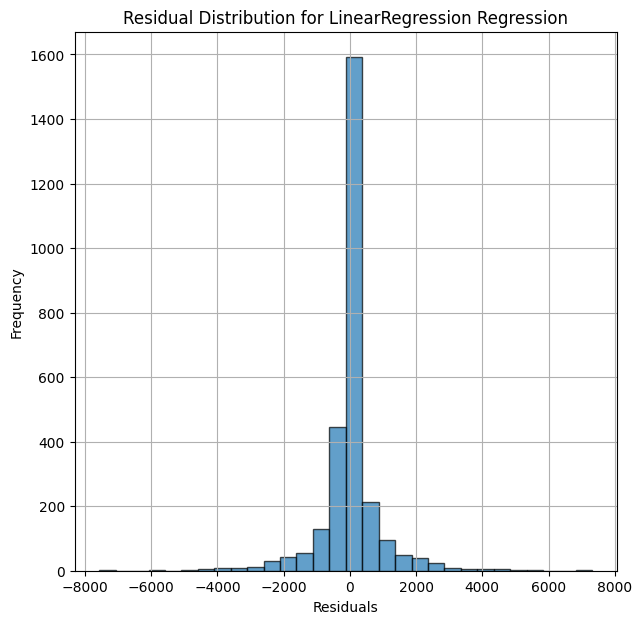

MemoryError: Unable to allocate 32.5 GiB for an array with shape (2224, 1961256) and data type float64

In [32]:
print('\n____________ K-fold cross validation ____________')
cv = KFold(n_splits=5,shuffle=True,random_state=37) # cv data generator

run_new_evaluation = 1
if run_new_evaluation == 1:
    models = [
        (LinearRegression(), "LinearRegression"),
        (Pipeline([('poly_features', PolynomialFeatures(degree=10)), ('lin_reg', LinearRegression())]), "PolynomialRegression"),
        (DecisionTreeRegressor(max_depth=10), "DecisionTreeRegressor"),
        (lgb.LGBMRegressor(), "LightGBM"),
        (XGBRegressor(), "XGBoostRegressor"),
        (RandomForestRegressor(n_estimators=100), "RandomForestRegressor"),
        (KNeighborsRegressor(n_neighbors=5), "KNeighbour"),
    ]
    
    for model, model_name in models:
        evaluate_and_plot(model, model_name, X_train, y_train, cv)

else:
    model_names = [
        "LinearRegression",
        "PolynomialRegression",
        "DecisionTreeRegressor",
        "RandomForestRegressor",
        "LightGBM",
        "XGBoostRegressor",
        "KNeighbour"
    ]
    
    for model_name in model_names:
        load_and_print_rmse_with_plot(model_name)


# **STEP 7: FINE-TUNING**

# **STEP 8: ANALYZE AND TEST YOUR SOLUTION:**

**8.1. Pick the best model - the solution**

**8.2. Run on test-data and predicts**